In [1]:
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
from scipy.sparse import csc_matrix

import os

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns



def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
all_metrics = """Control	0.5928	0.569088	0.588754	0.714715	0.718895	0.723575	0.695935	0.701095	0.699836
BROCKMAN	0.54574	0.500141	0.499691	0.682654	0.642841	0.65918	0.67829	0.641288	0.645486
Cusanovich2018	0.943846	0.745106	0.758834	0.941653	0.851342	0.854749	0.941908	0.825158	0.813651
cisTopic	0.530953	0.529333	0.49712	0.645415	0.643513	0.629724	0.639389	0.644356	0.619491
chromVAR_kmers	0.467463	0.430748	0.417099	0.610438	0.577779	0.540338	0.555603	0.577083	0.537387
chromVAR_motifs	0.3906	0.369871	0.290375	0.520555	0.510661	0.43916	0.519439	0.512255	0.432029
chromVAR_kmers_pca	0.458582	0.492114	0.436538	0.612727	0.622779	0.568588	0.602843	0.624776	0.563519
chromVAR_motifs_pca	0.390955	0.367727	0.298085	0.524297	0.48803	0.427891	0.522027	0.489588	0.417594
GeneScoring	0.00267149	0.111998	0.103837	0.00570611	0.20693	0.179649	0.011055	0.1803	0.149194
GeneScoring_pca	0.09707	0.135782	0.106418	0.117303	0.222123	0.200712	0.113637	0.205834	0.179901
Cicero	0.00687868	0.142307	0.397534	0.0111747	0.389042	0.589552	0.0168549	0.249484	0.48291
Cicero_pca	0.448862	0.443354	0.423914	0.534053	0.566373	0.562634	0.522034	0.547409	0.50774
SnapATAC	0.804994	0.860076	0.770361	0.84069	0.874407	0.816767	0.841453	0.875022	0.816121
Scasat	0.613989	0.634201	0.590497	0.724743	0.74057	0.708525	0.715335	0.741861	0.705696
scABC	0.20426	0.448982	0.465818	0.247493	0.583171	0.568088	0.229539	0.529003	0.531906
SCRAT	0.444511	0.448028	0.457745	0.610931	0.581328	0.59356	0.596725	0.582187	0.592494
SCRAT_pca	0.469748	0.405095	0.461812	0.606473	0.585137	0.597519	0.601129	0.571914	0.591323
"""

    
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.



In [2]:
%%R -o features -o cells -o mtx
df_count = readRDS('./input/bonemarrow_cov1000.rds')
mtx=as.matrix(df_count)
features = df_count@Dimnames[[1]]
cells = df_count@Dimnames[[2]]

R[write to console]: Loading required package: Matrix



In [3]:
# format the data
mtx=csc_matrix(mtx).transpose()
cells = cells.tolist()
features = features.tolist()

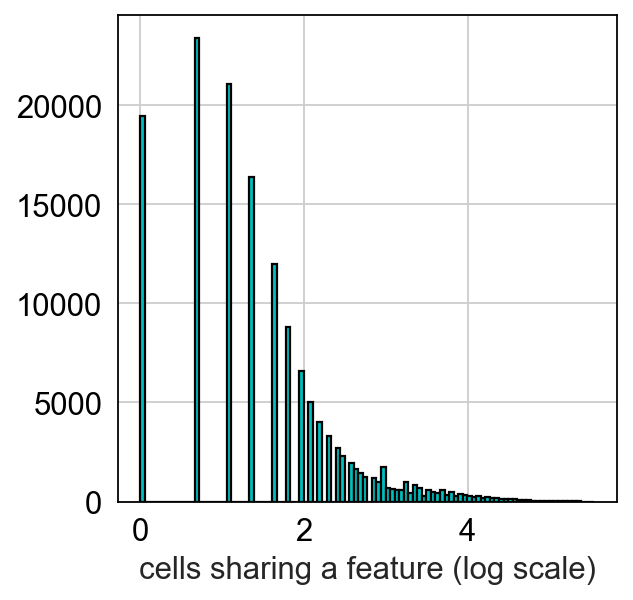

AnnData object with n_obs × n_vars = 1200 × 147303 
    obs: 'cell_type', 'n_features', 'nb_features'
    var: 'n_cells', 'commonness'


... storing 'cell_type' as categorical


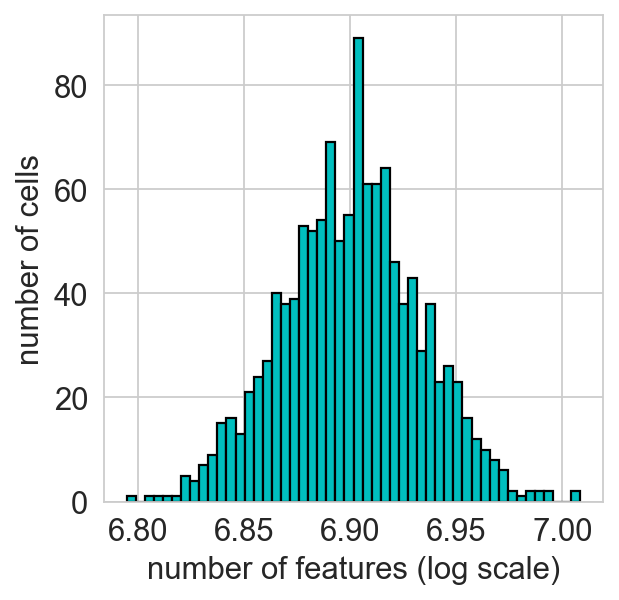

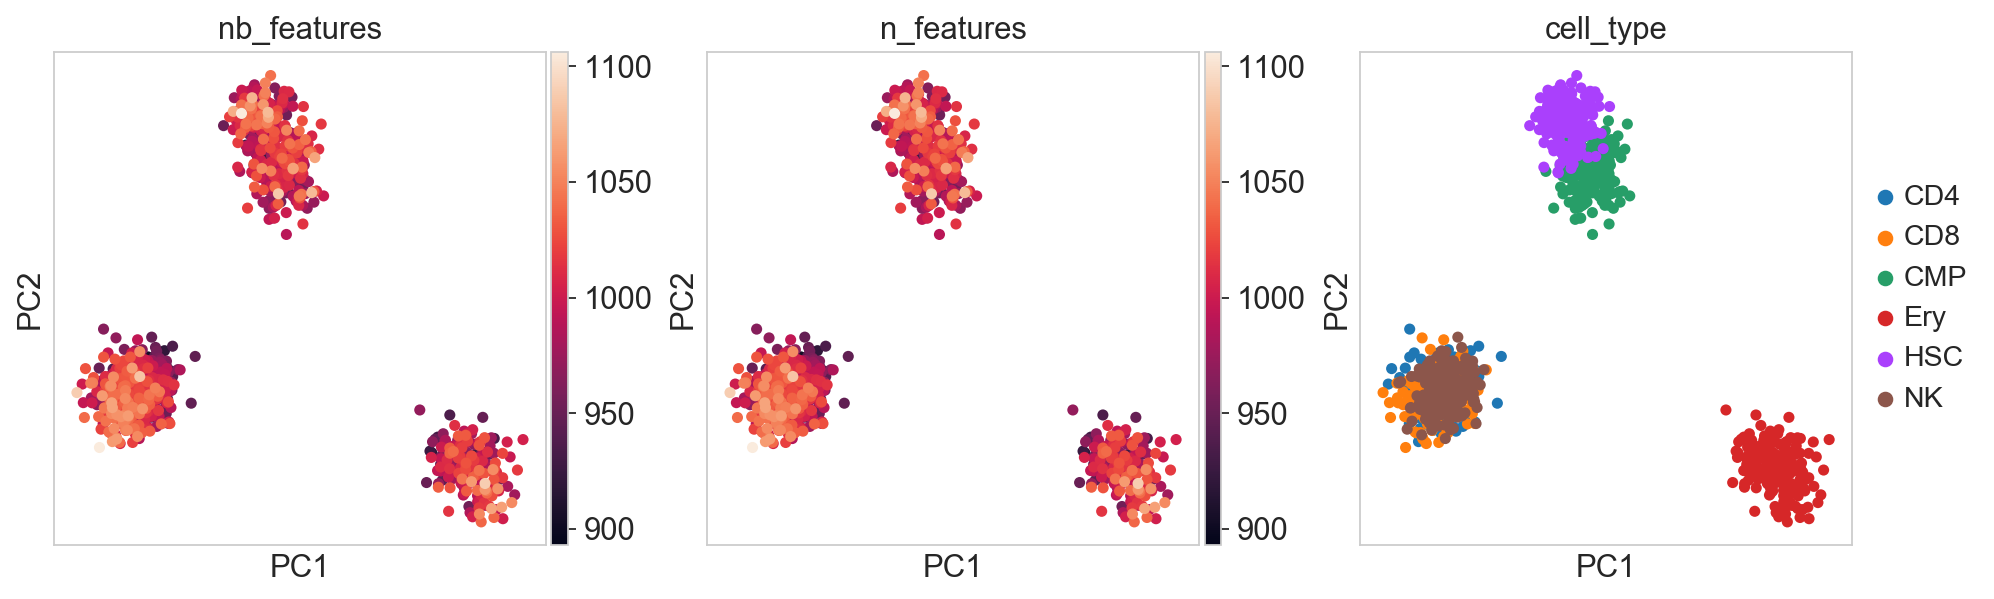

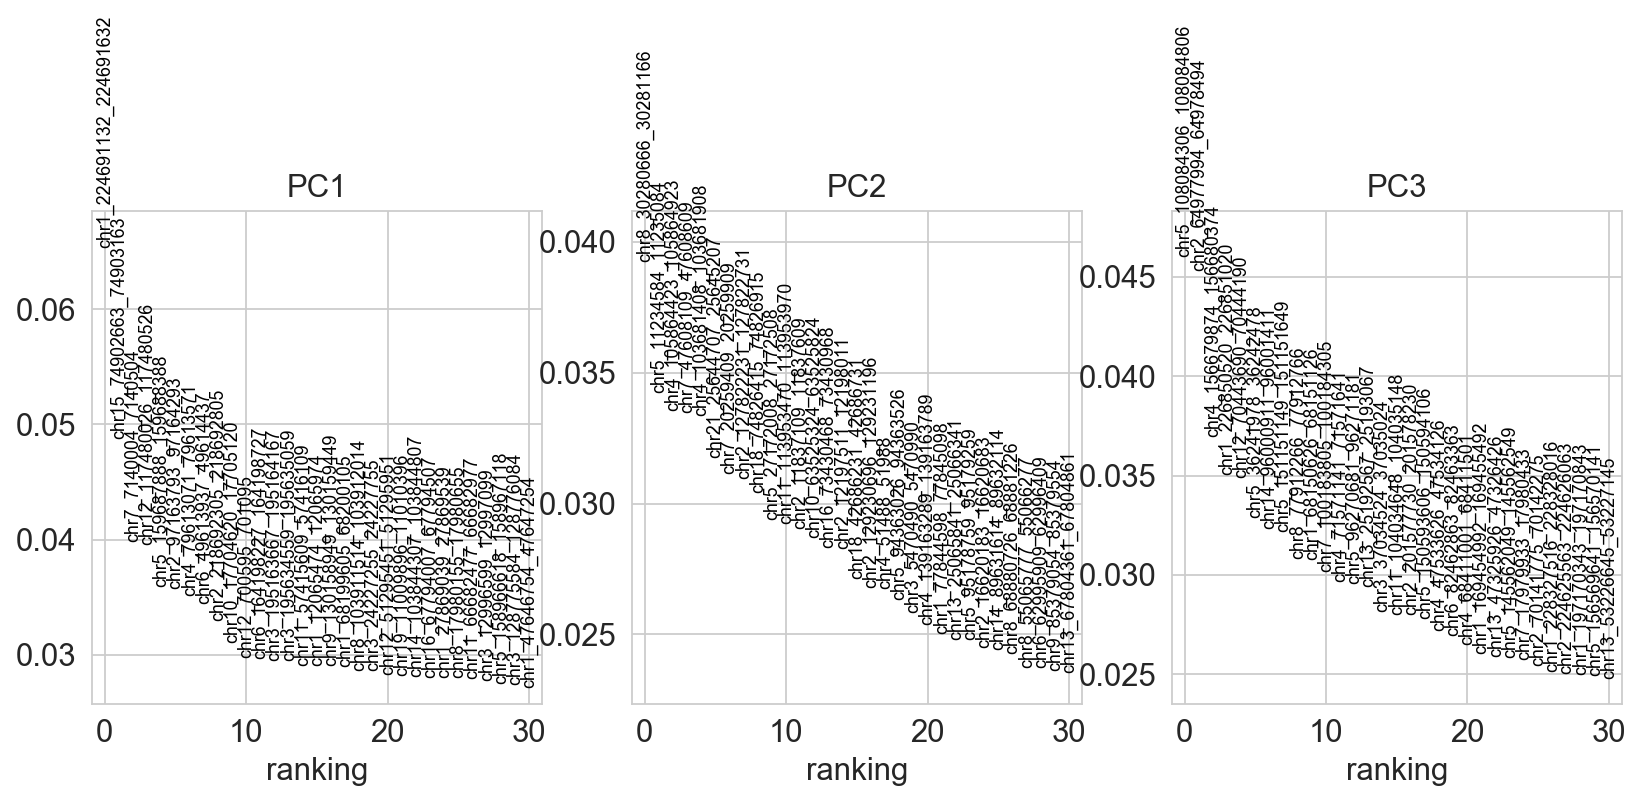

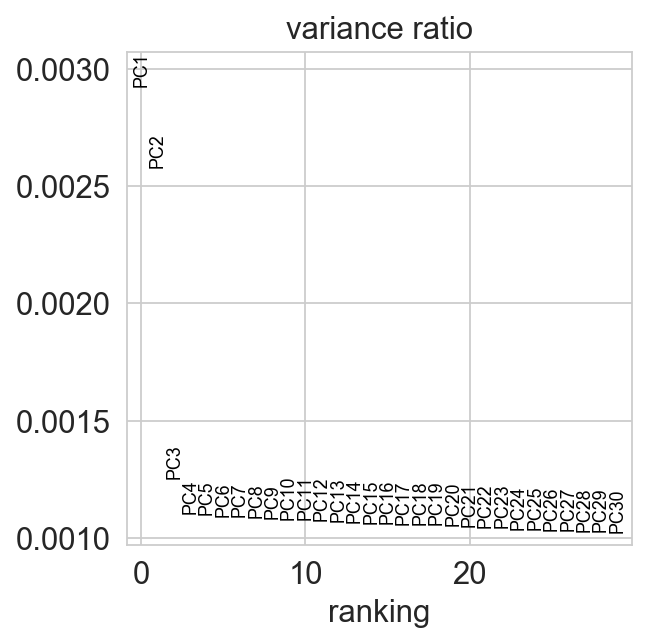

In [8]:
adata = ad.AnnData(mtx,
                   obs=pd.DataFrame(index=cells),
                   var=pd.DataFrame(index=features))

# load metadata
metadata = pd.read_csv('./input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label']))
adata.obs['cell_type'] = metadata['label']

epi.pp.binarize(adata)
#print(adata)

#epi.pp.commonness_features(adata, binary=True)
#epi.pp.coverage_cells(adata, binary=True)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
#epi.pp.filter_features(adata, max_cells=1190)
#print(adata)
#epi.pp.select_var_feature(adata, nb_features=10000)
#adata
epi.pp.commonness_features(adata, binary=True, log=True)
epi.pp.coverage_cells(adata, binary=True, log=True)

#sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=False,
#                                      max_fraction=0.05, key_added=None, layers=None,
#                                      layer_norm=None, inplace=True)

#sc.pp.log1p(adata)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
#adata = adata[:, adata.var['highly_variable']]
print(adata)

adatareduced = adata.copy()
epi.pp.pca(adatareduced, n_comps=30)
sc.pl.pca_overview(adatareduced, color=['nb_features', 'n_features', 'cell_type'])

In [9]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

20


... storing 'cell_type' as categorical


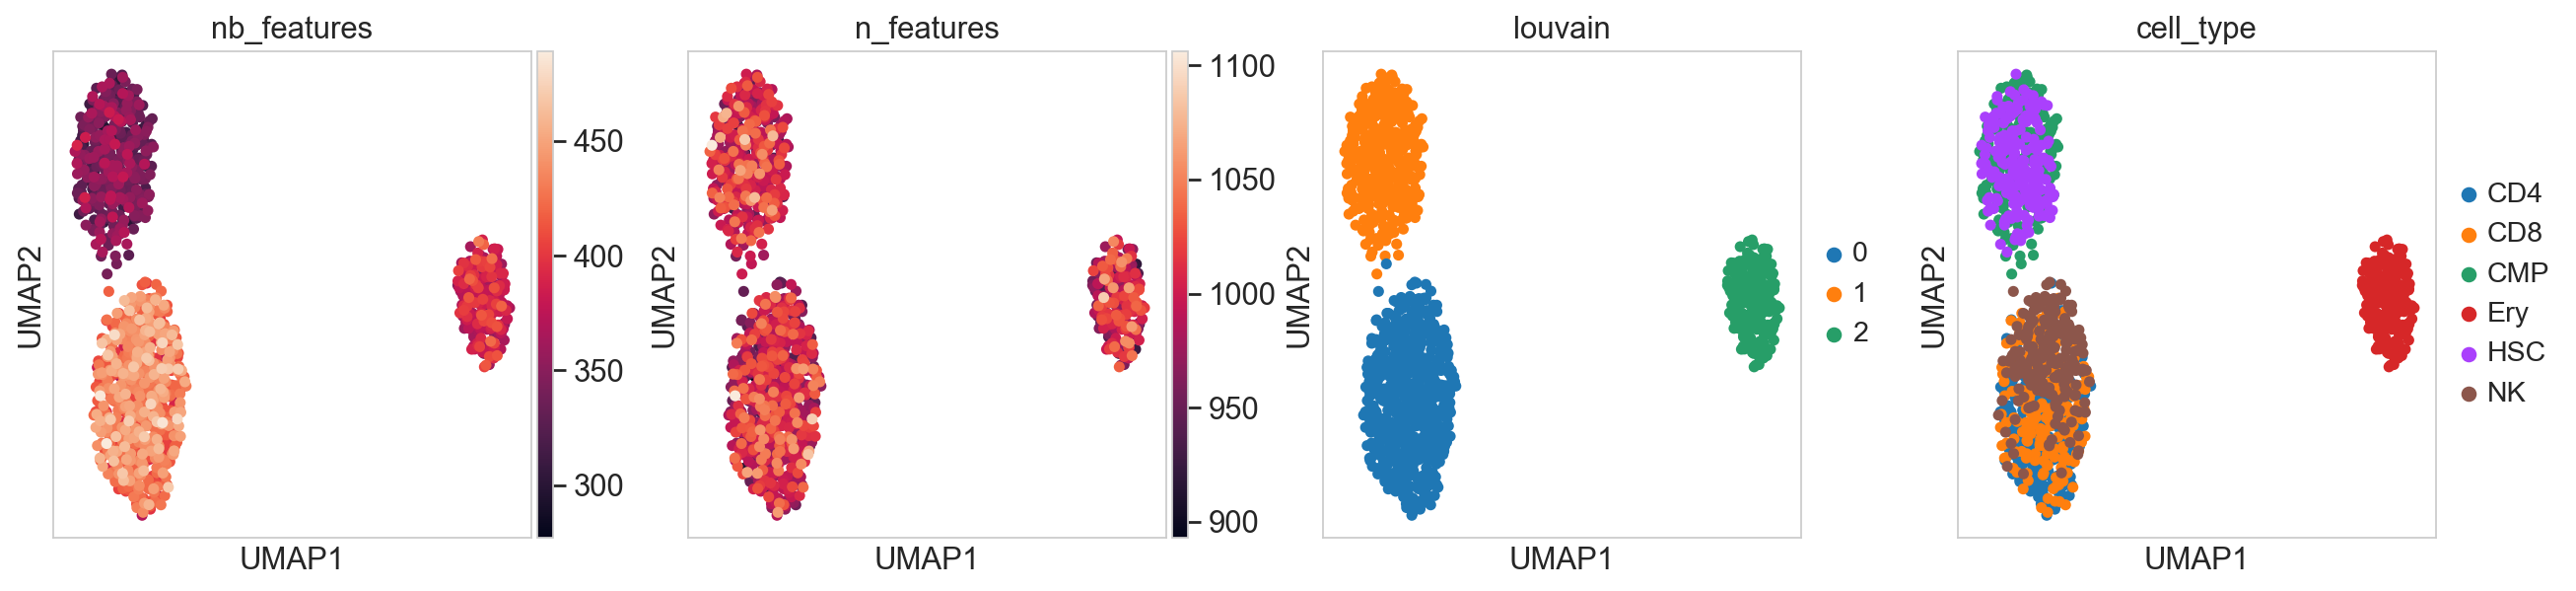

25


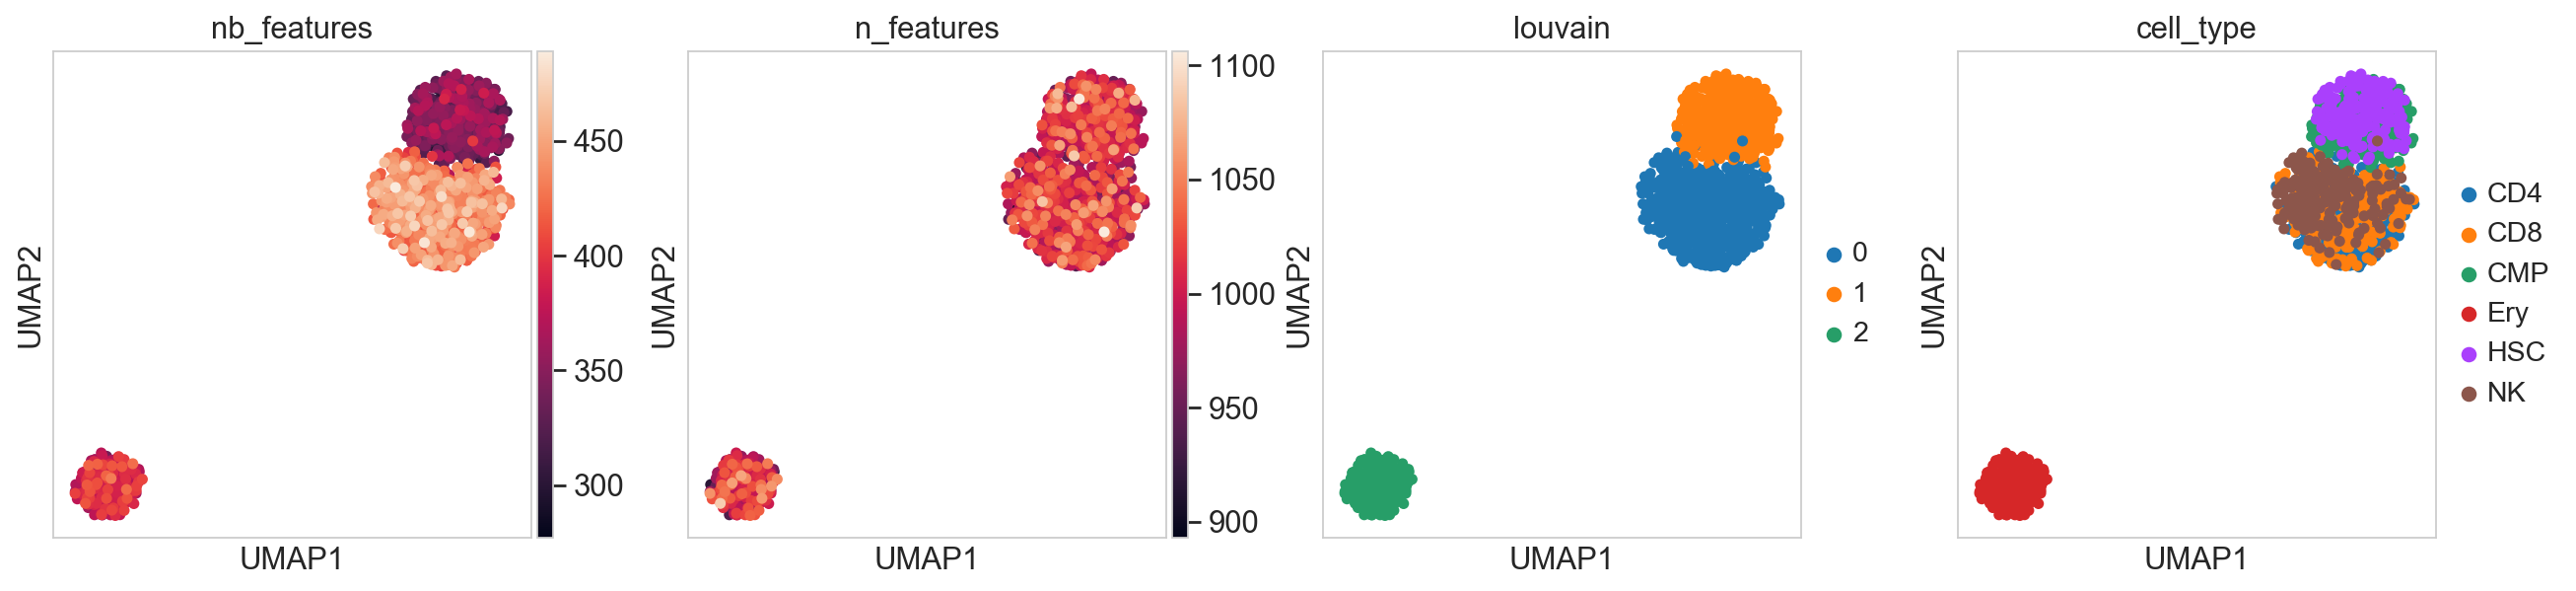

30


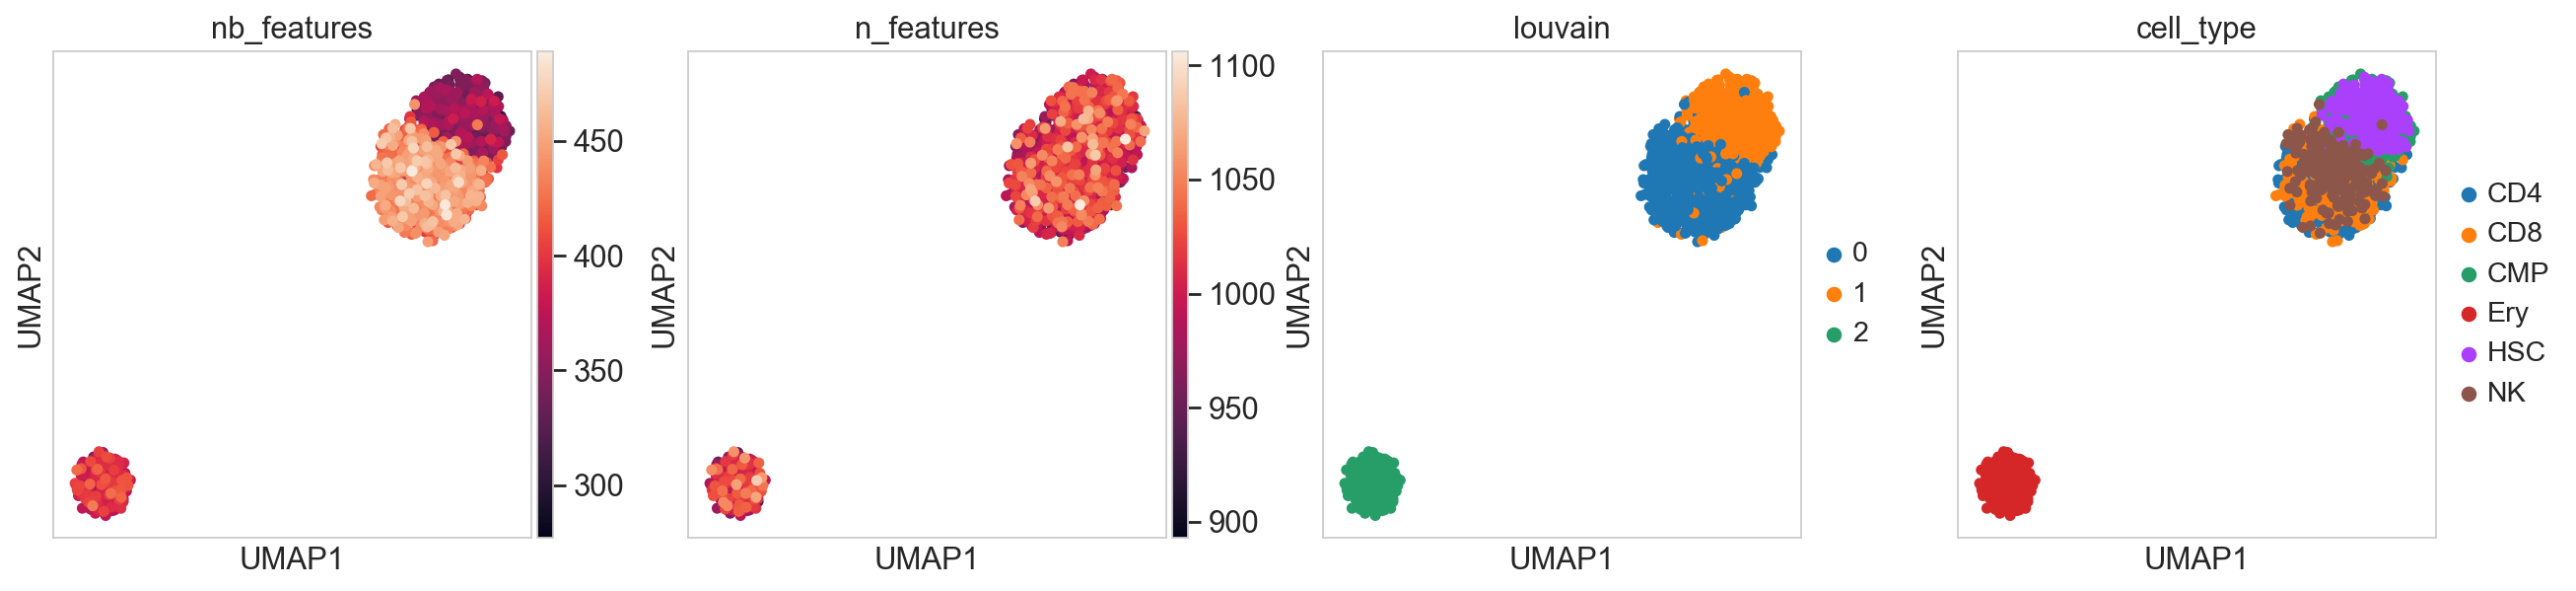

35


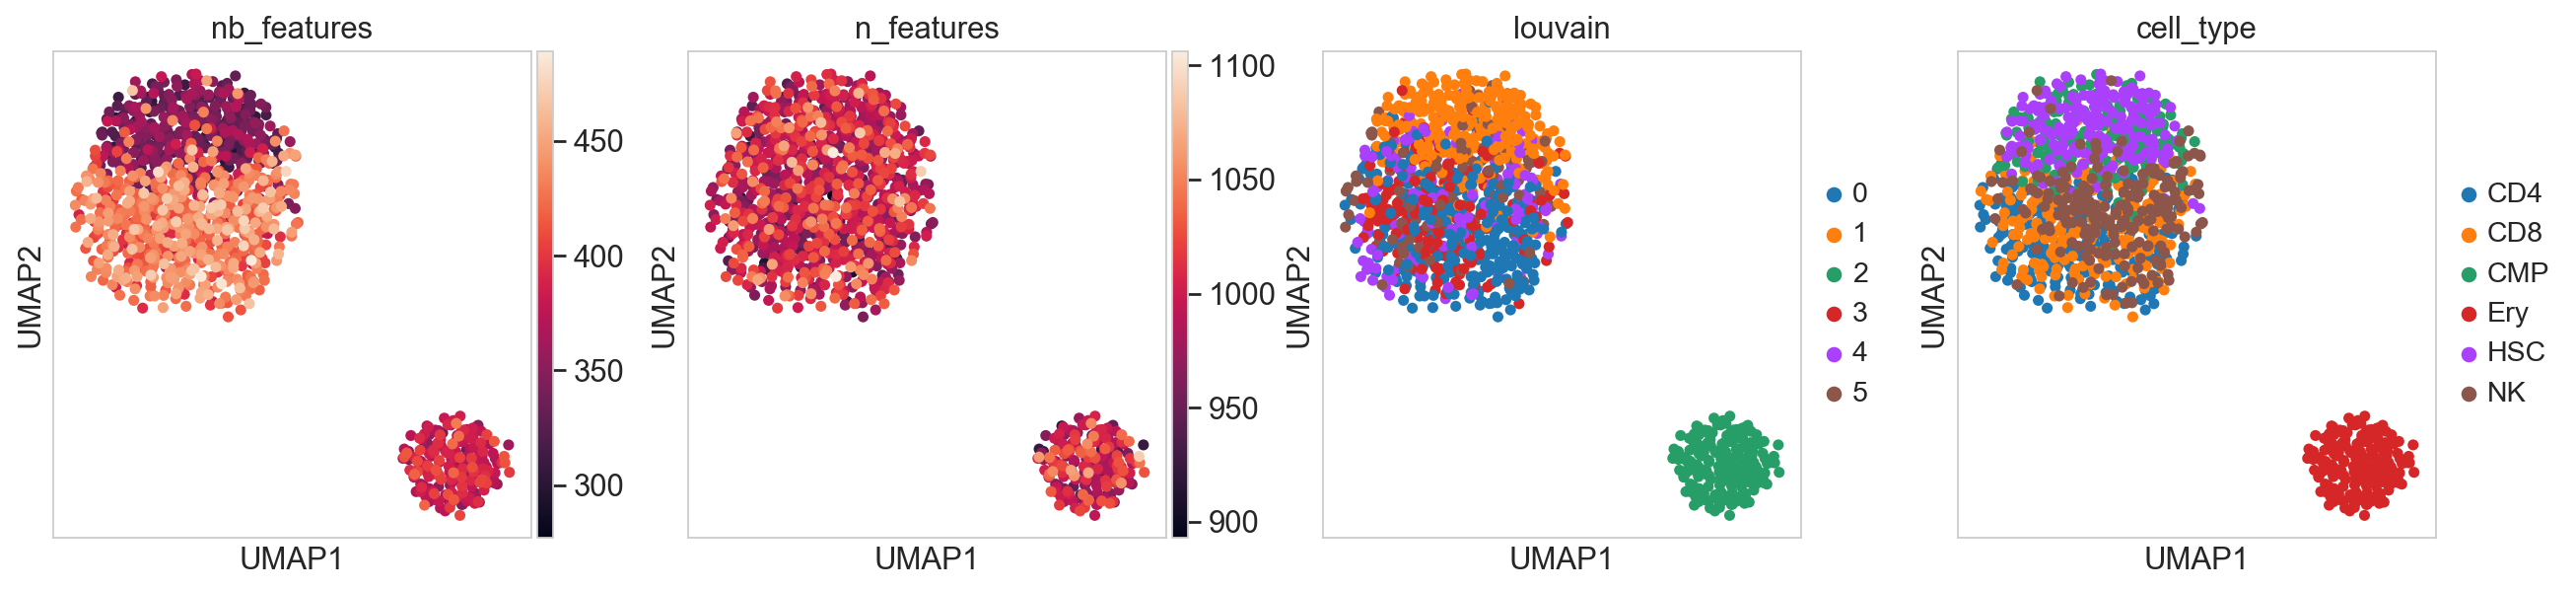

40


KeyboardInterrupt: 

In [96]:
# test to find the number of PC
adatareduced = adata.copy()
for n in range(20, 50, 5):
    print(n)
    epi.pp.pca(adatareduced, n_comps=n)
    sc.pp.neighbors(adatareduced, n_neighbors=15)
    epi.tl.umap(adatareduced)
    epi.tl.louvain(adatareduced)
    #sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
    sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

5


... storing 'cell_type' as categorical


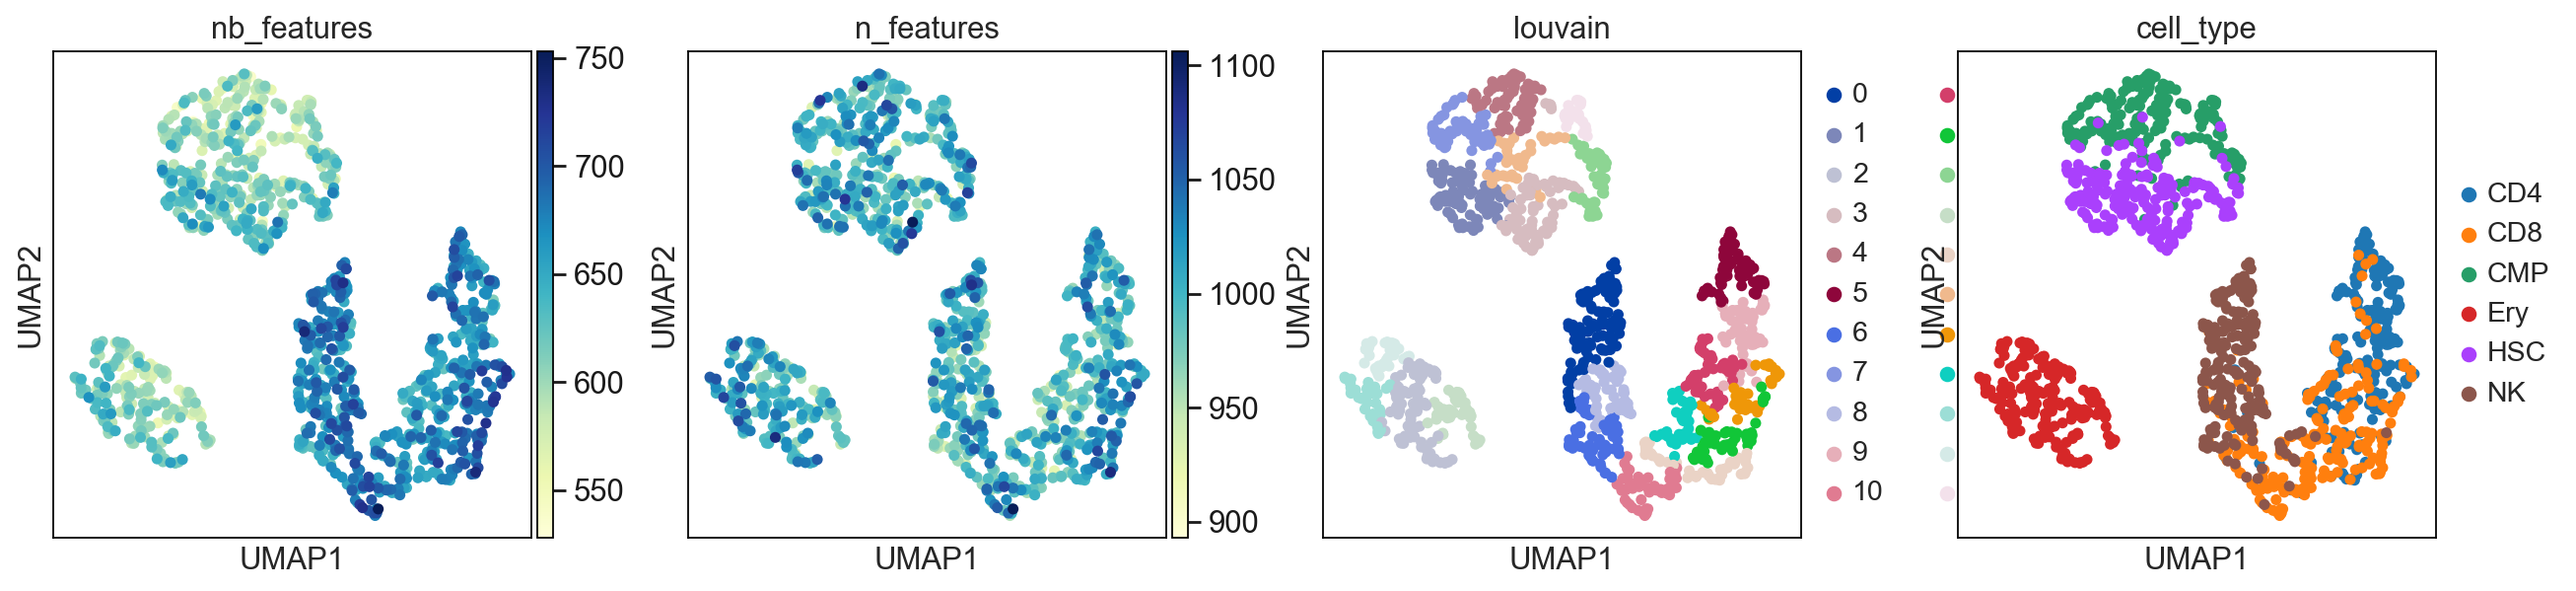

10


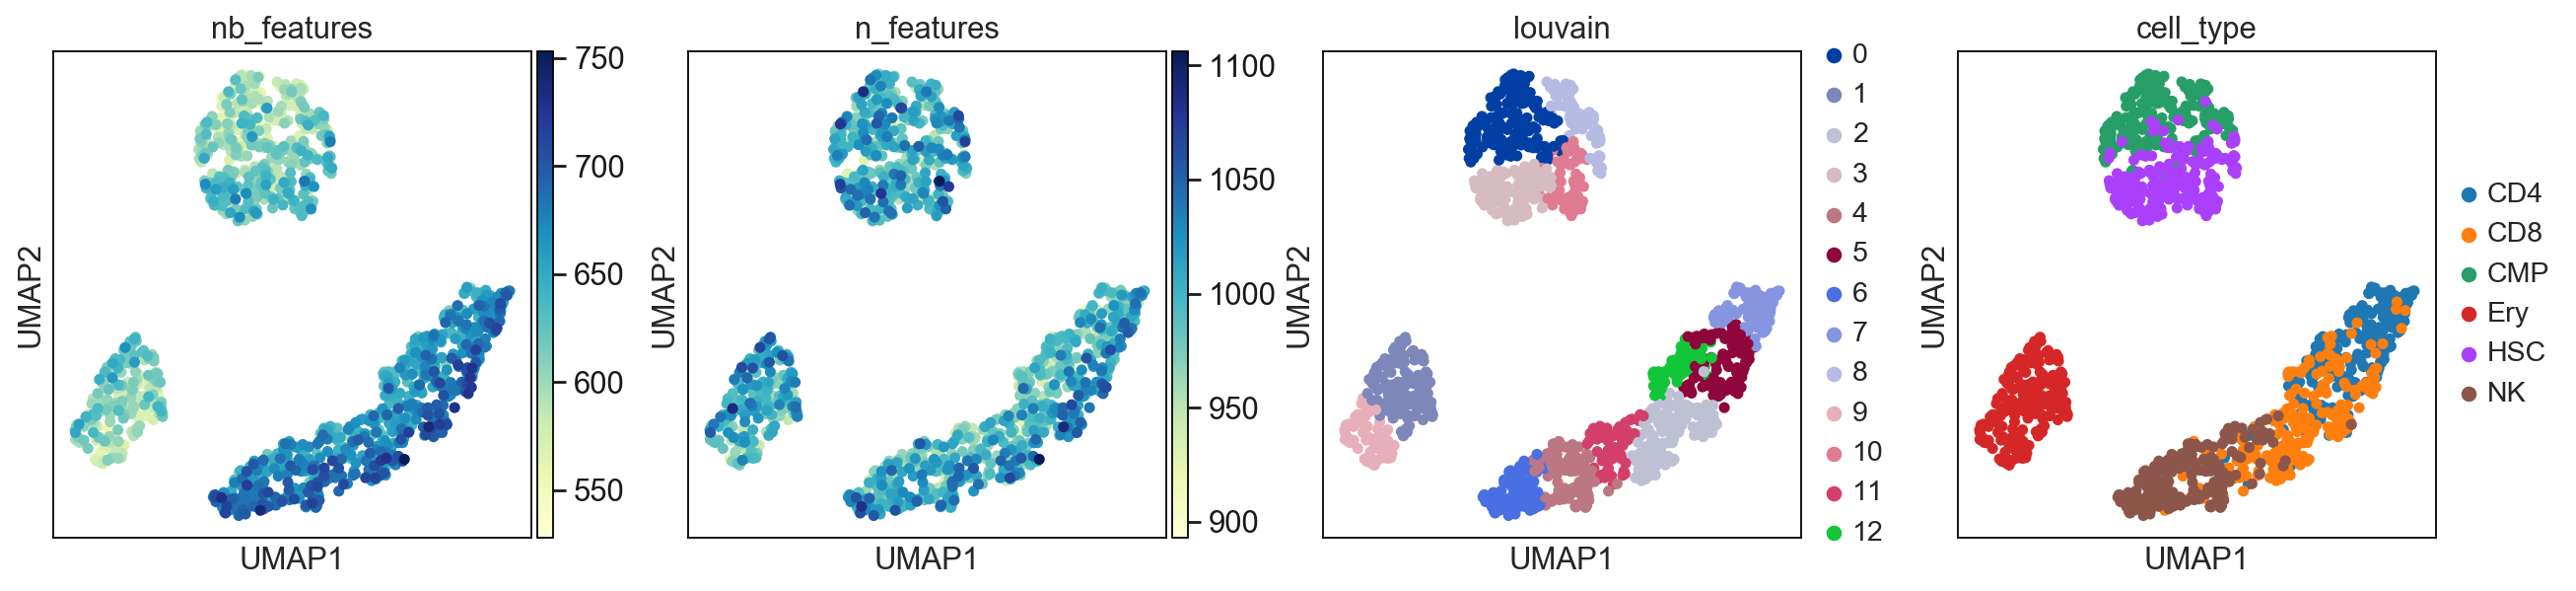

15


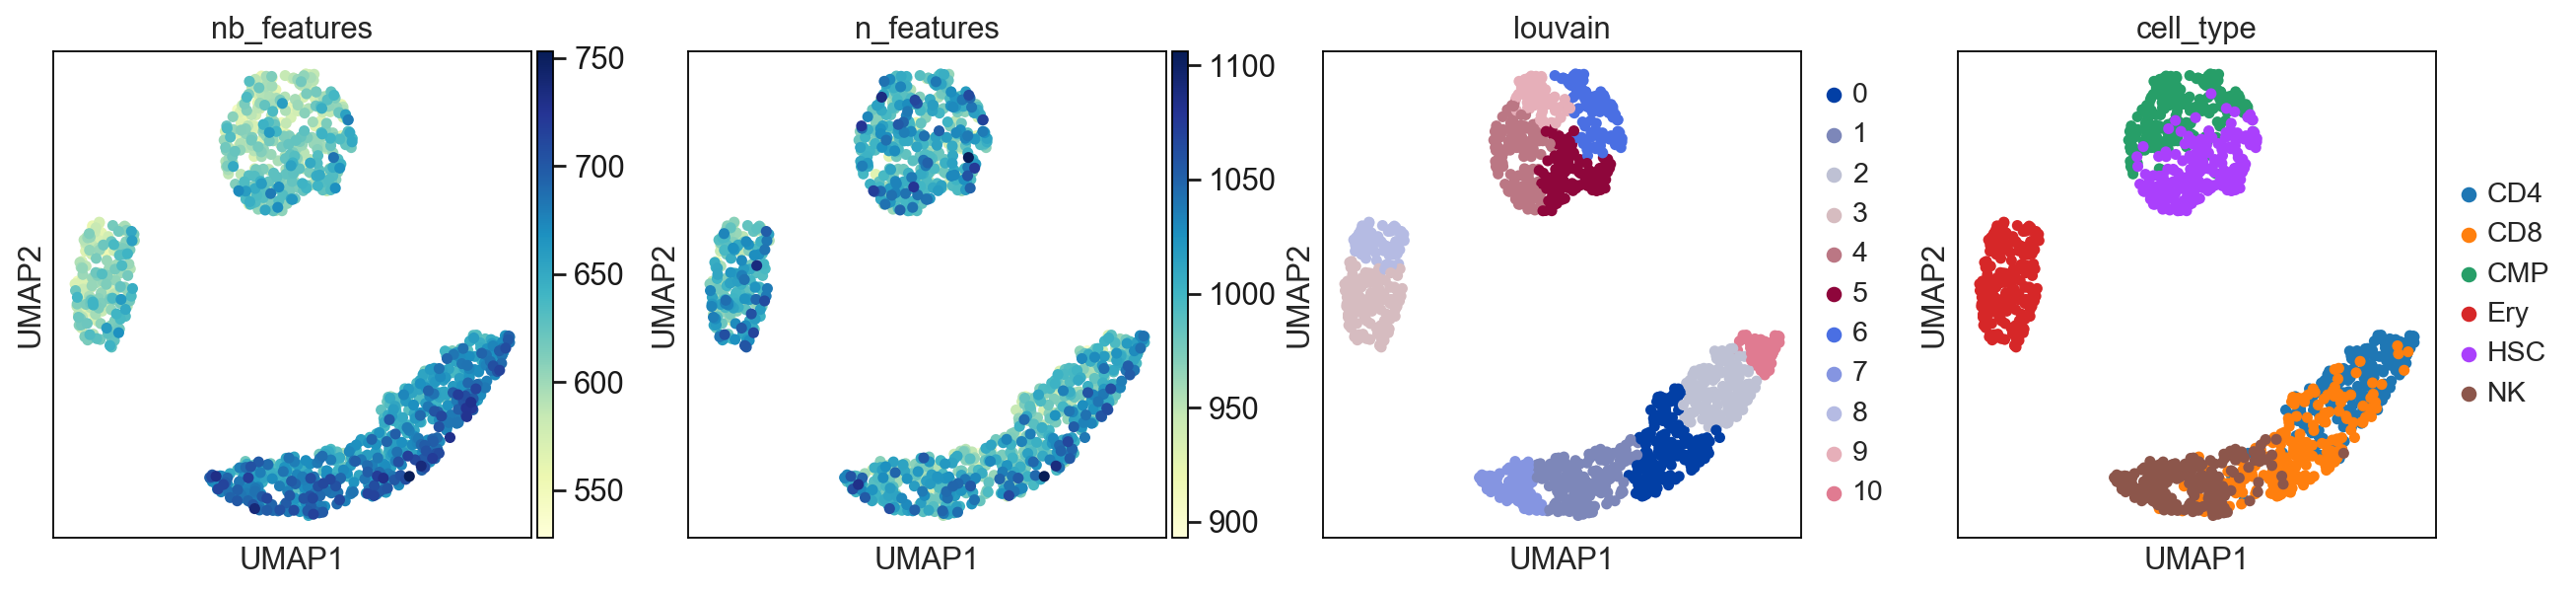

In [84]:
# test to find the number of neighbors
adatareduced = adata.copy()
for n in range(5, 20, 5):
    print(n)
    epi.pp.pca(adatareduced, n_comps=3)
    sc.pp.neighbors(adatareduced, n_neighbors=n)
    epi.tl.umap(adatareduced)
    epi.tl.louvain(adatareduced)
    #sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
    sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

... storing 'cell_type' as categorical


step 0
got 37 at resolution 1.5
step 1
got 27 at resolution 0.75
step 2
got 16 at resolution 0.375
step 3
got 9 at resolution 0.1875
step 4
got 6 at resolution 0.09375


... storing 'label' as categorical


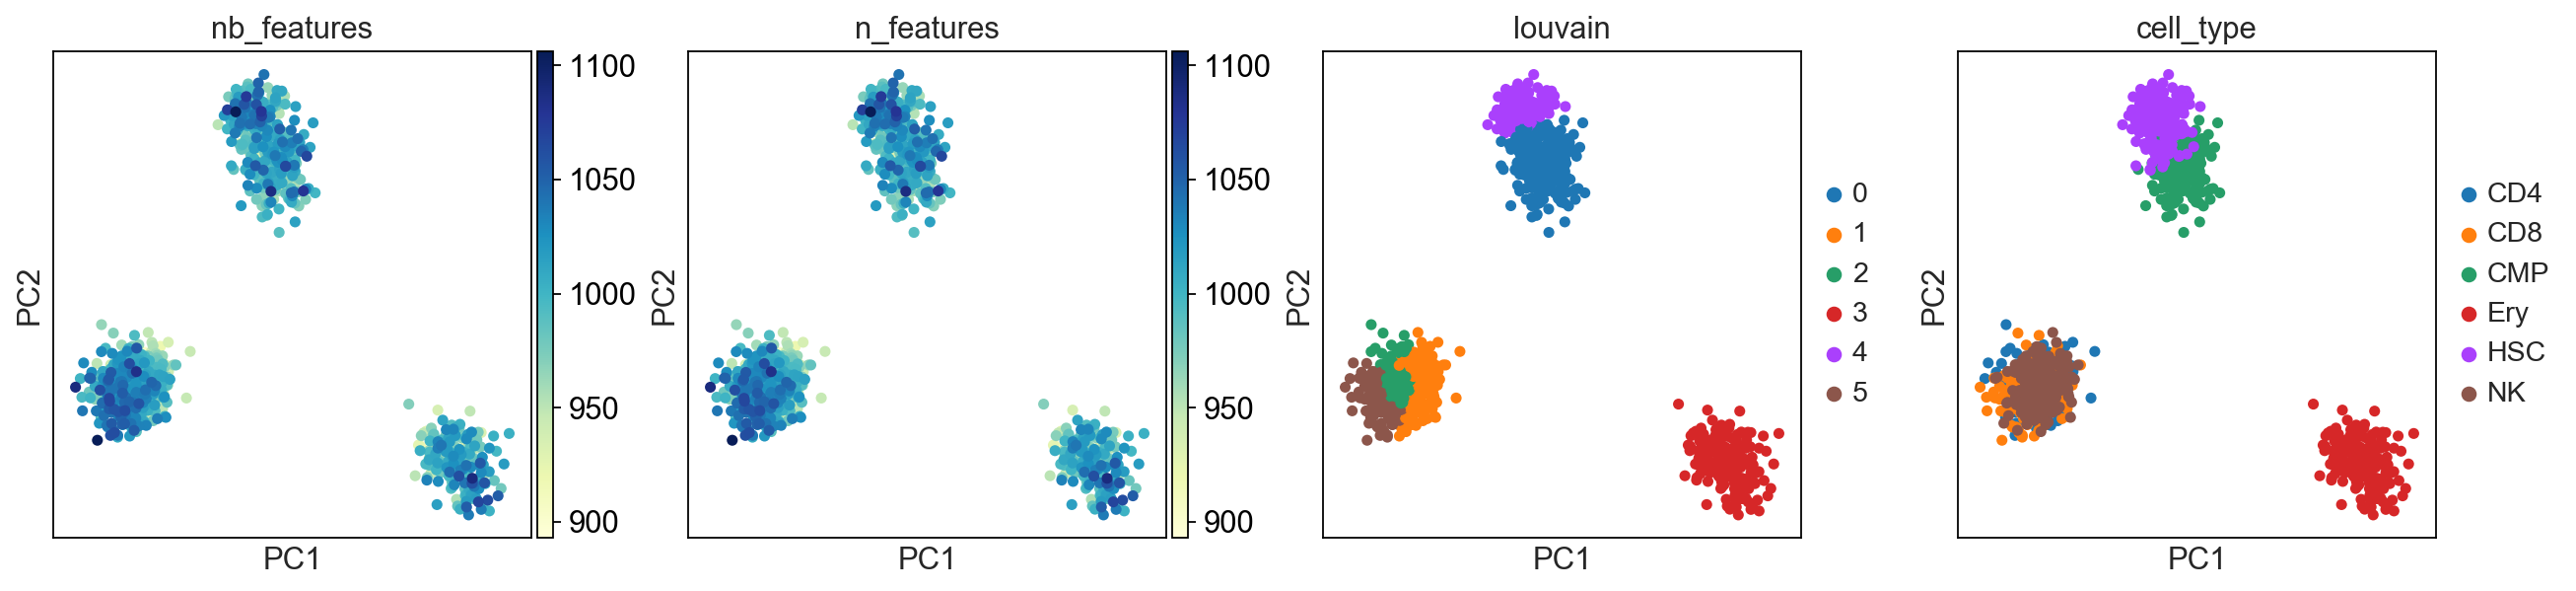

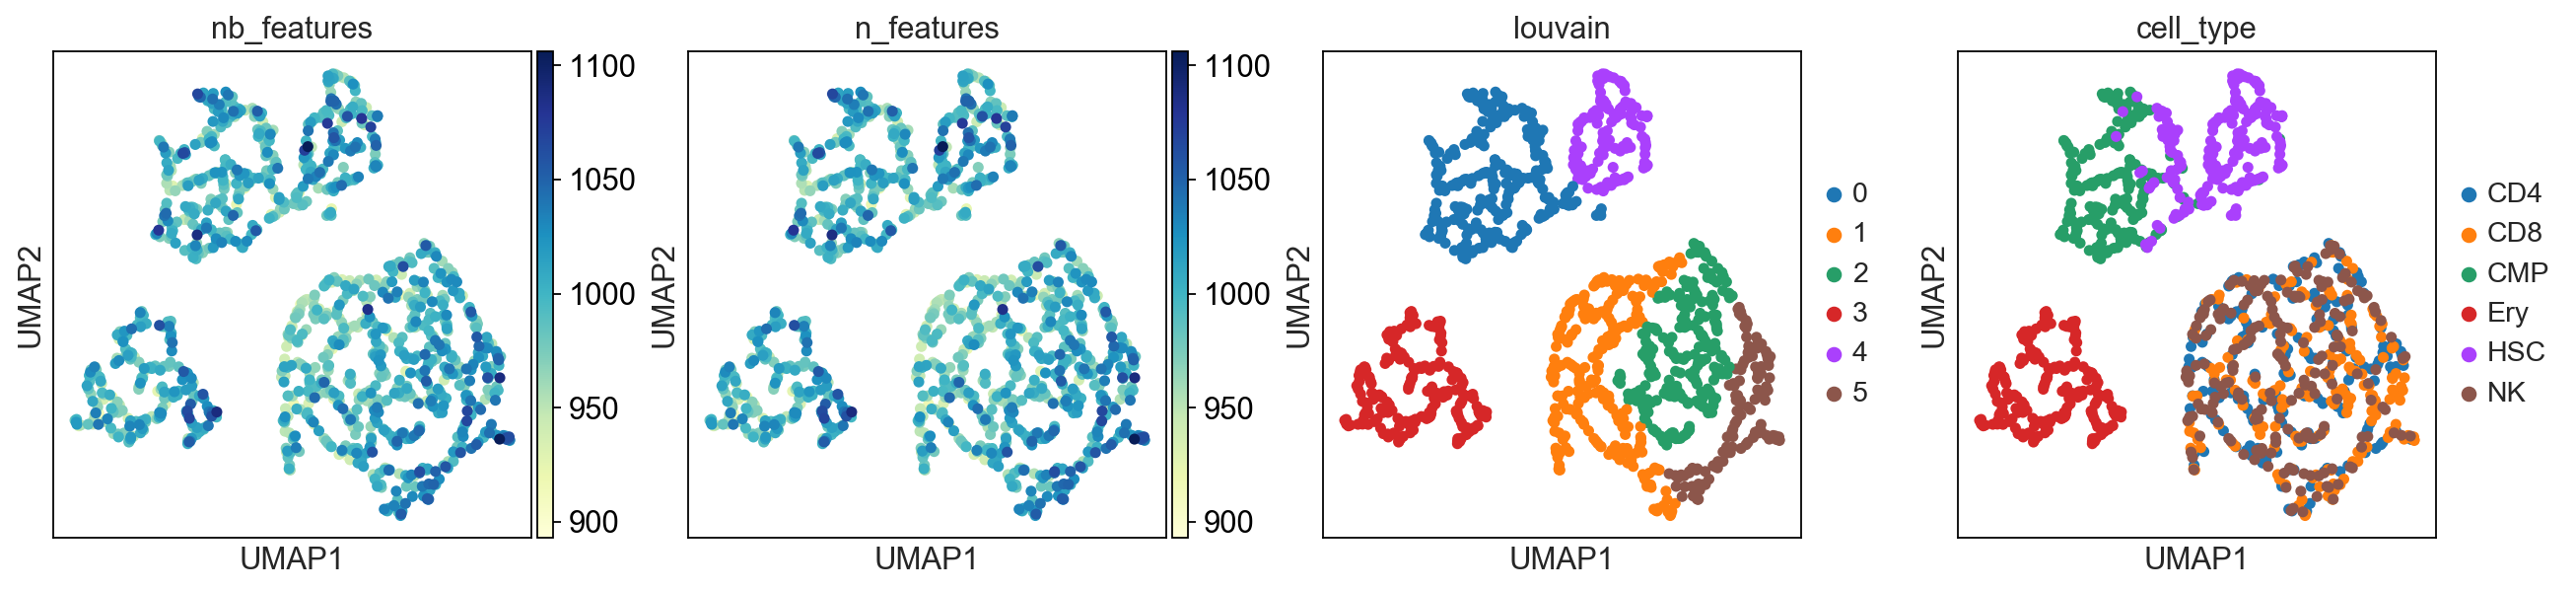

0.4928542924908052 0.48946794460073667 0.47252499599518416


In [13]:
adatareduced = adata.copy()
# convert the cell label to standard label
adatareduced.obs['label'] = adatareduced.obs['cell_type']


epi.pp.pca(adatareduced, n_comps=10)
sc.pp.neighbors(adatareduced, n_neighbors=15)
epi.tl.umap(adatareduced)
#epi.tl.louvain(adatareduced)
getNClusters(adatareduced,n_cluster=num_clusters)
#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adatareduced.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])

sc.pl.pca(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])
sc.pl.umap(adatareduced, color=['nb_features', 'n_features', 'louvain', 'cell_type'])

print(ari_louvain, ari_kmeans, ari_hc)

0.39055605813170824
step 0
got 17 at resolution 1.5
step 1
got 12 at resolution 0.75
step 2
got 6 at resolution 0.375


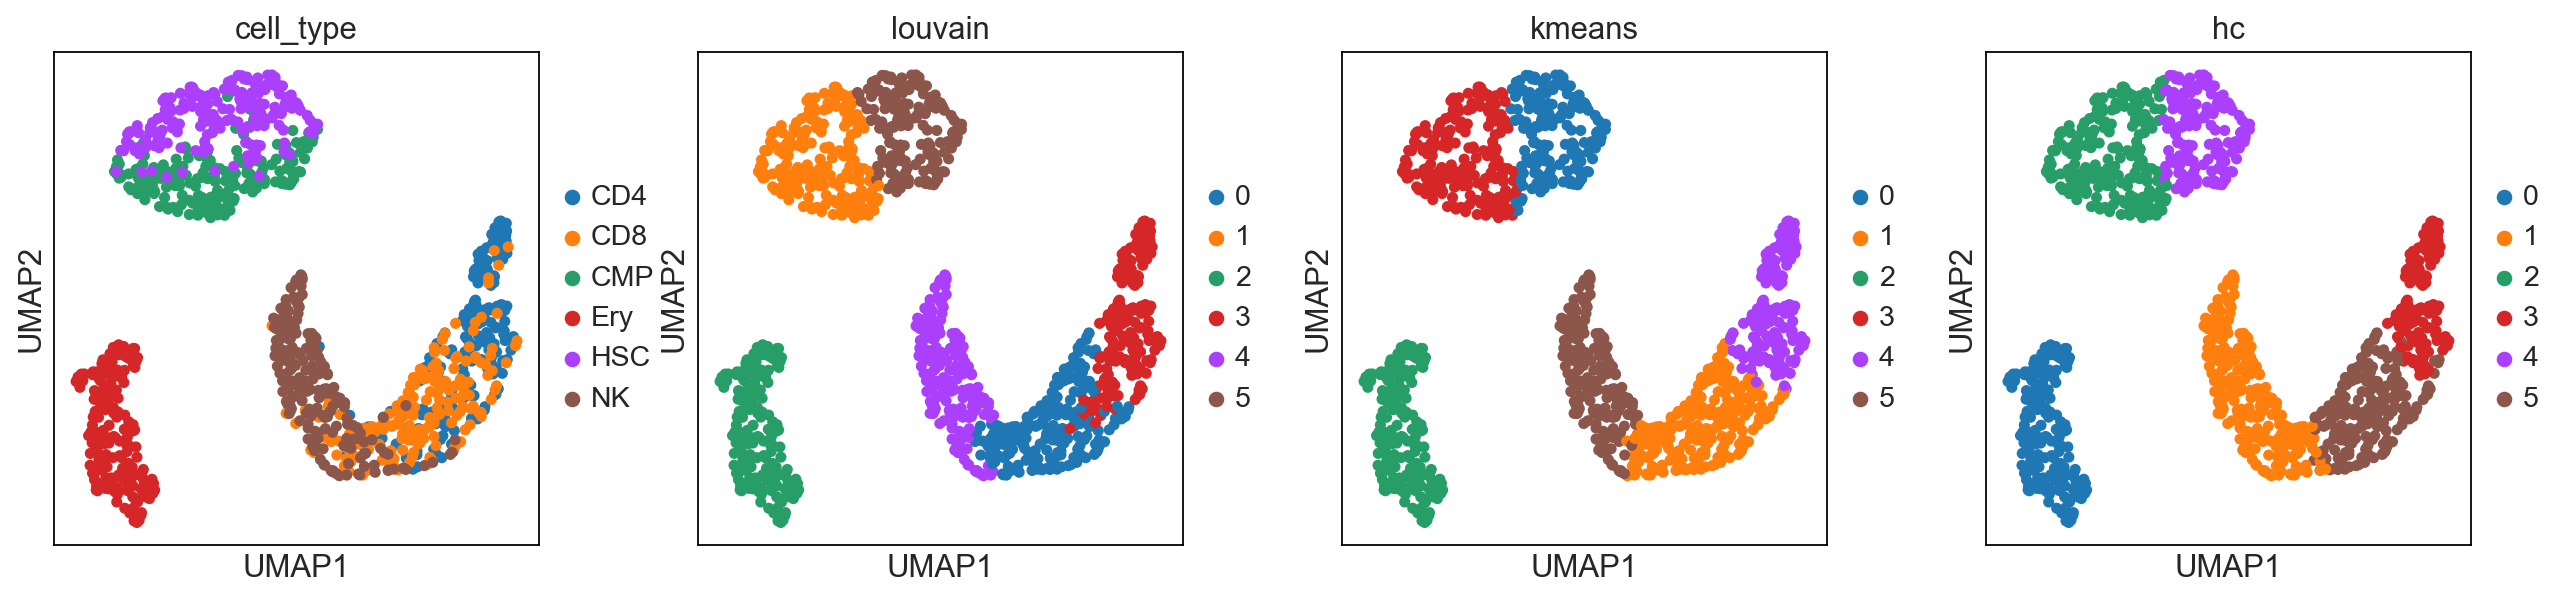

['BROCKMAN', '0.54574', '0.500141', '0.499691', '0.682654', '0.642841', '0.65918', '0.67829', '0.641288', '0.645486']
['Cusanovich2018', '0.943846', '0.745106', '0.758834', '0.941653', '0.851342', '0.854749', '0.941908', '0.825158', '0.813651']
['cisTopic', '0.530953', '0.529333', '0.49712', '0.645415', '0.643513', '0.629724', '0.639389', '0.644356', '0.619491']
['chromVAR_kmers', '0.467463', '0.430748', '0.417099', '0.610438', '0.577779', '0.540338', '0.555603', '0.577083', '0.537387']
['chromVAR_motifs', '0.3906', '0.369871', '0.290375', '0.520555', '0.510661', '0.43916', '0.519439', '0.512255', '0.432029']
['chromVAR_kmers_pca', '0.458582', '0.492114', '0.436538', '0.612727', '0.622779', '0.568588', '0.602843', '0.624776', '0.563519']
['chromVAR_motifs_pca', '0.390955', '0.367727', '0.298085', '0.524297', '0.48803', '0.427891', '0.522027', '0.489588', '0.417594']
['GeneScoring', '0.00267149', '0.111998', '0.103837', '0.00570611', '0.20693', '0.179649', '0.011055', '0.1803', '0.14919

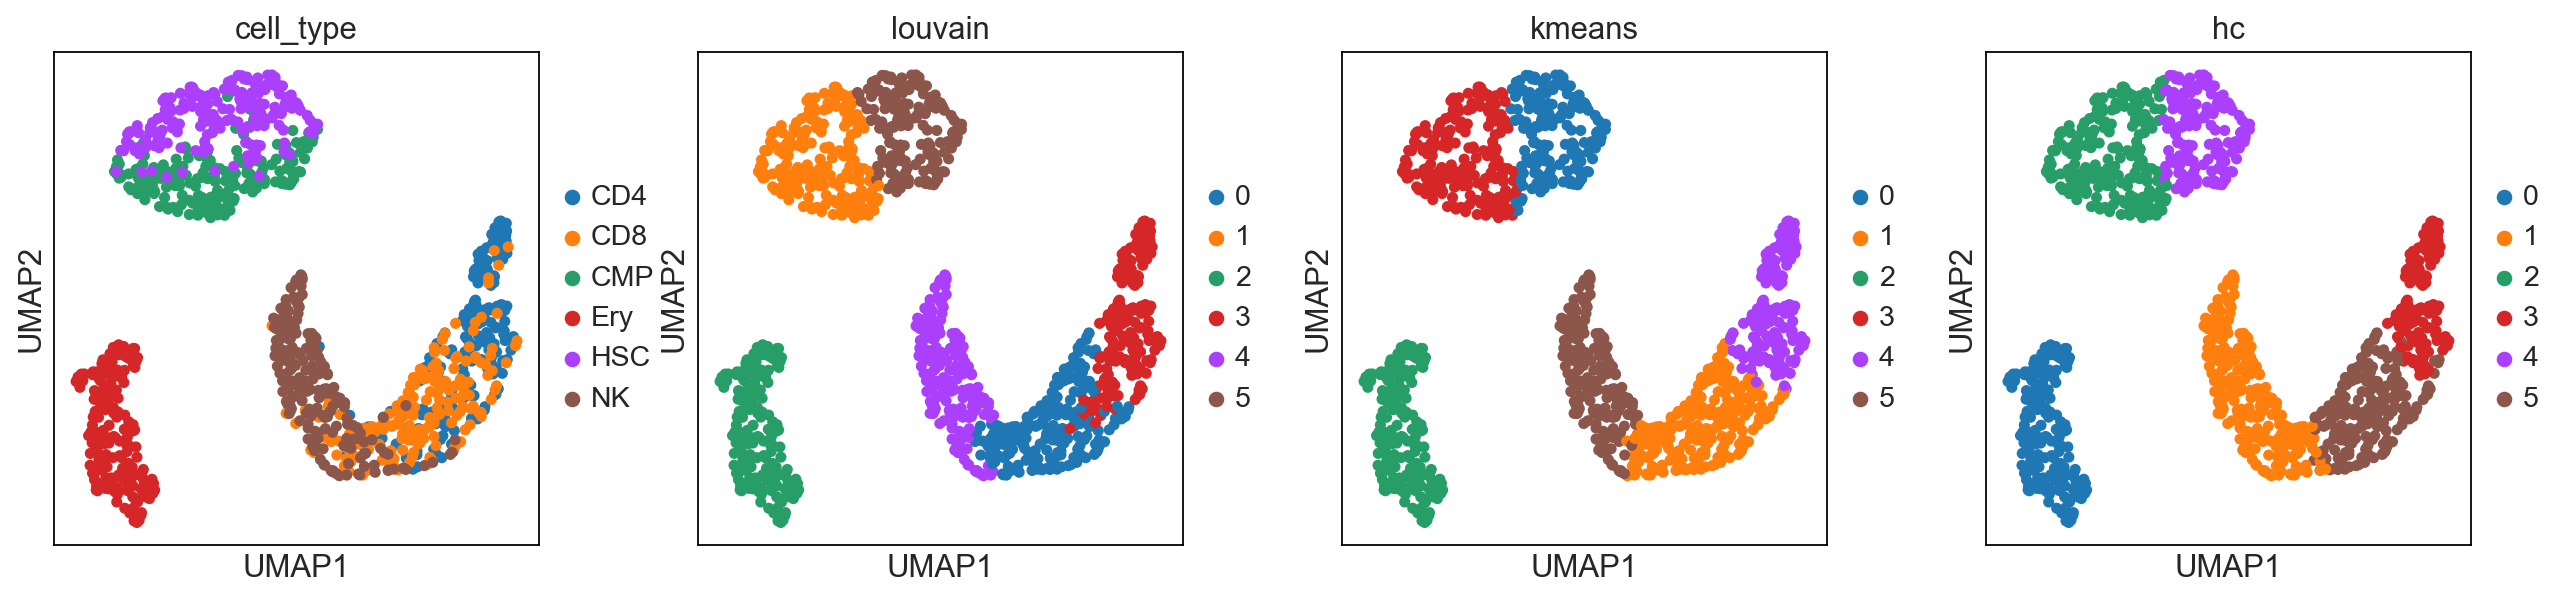

ARI_Louvain  ARI_kmeans    ARI_HC  AMI_Louvain  \
epiScanpy-adata         0.553161    0.555443  0.564390     0.682854   
BROCKMAN                0.545740    0.500141  0.499691     0.682654   
Cusanovich2018          0.943846    0.745106  0.758834     0.941653   
cisTopic                0.530953    0.529333  0.497120     0.645415   
chromVAR_kmers          0.467463    0.430748  0.417099     0.610438   
chromVAR_motifs         0.390600    0.369871  0.290375     0.520555   
chromVAR_kmers_pca      0.458582    0.492114  0.436538     0.612727   
chromVAR_motifs_pca     0.390955    0.367727  0.298085     0.524297   
GeneScoring             0.002671    0.111998  0.103837     0.005706   
GeneScoring_pca         0.097070    0.135782  0.106418     0.117303   
Cicero                  0.006879    0.142307  0.397534     0.011175   
Cicero_pca              0.448862    0.443354  0.423914     0.534053   
SnapATAC                0.804994    0.860076  0.770361     0.840690   
Scasat                  0.613989    0.634201  0.590497     0.724743   
scABC                   0.204260    0.448982  0.465818     0.247493   
SCRAT                   0.444511    0.448028  0.457745     0.610931   
SCRAT_pca               0.469748    0.405095  0.461812     0.606473   

                     AMI_kmeans    AMI_HC  Homogeneity_Louvain  \
epiScanpy-adata        0.685847  0.689499             0.683916   
BROCKMAN               0.642841  0.659180             0.678290   
Cusanovich2018         0.851342  0.854749             0.941908   
cisTopic               0.643513  0.629724             0.639389   
chromVAR_kmers         0.577779  0.540338             0.555603   
chromVAR_motifs        0.510661  0.439160             0.519439   
chromVAR_kmers_pca     0.622779  0.568588             0.602843   
chromVAR_motifs_pca    0.488030  0.427891             0.522027   
GeneScoring            0.206930  0.179649             0.011055   
GeneScoring_pca        0.222123  0.200712             0.113637   
Cicero                 0.389042  0.589552             0.016855   
Cicero_pca             0.566373  0.562634             0.522034   
SnapATAC               0.874407  0.816767             0.841453   
Scasat                 0.740570  0.708525             0.715335   
scABC                  0.583171  0.568088             0.229539   
SCRAT                  0.581328  0.593560             0.596725   
SCRAT_pca              0.585137  0.597519             0.601129   

                     Homogeneity_kmeans  Homogeneity_HC               method  
epiScanpy-adata                0.685866        0.687776      epiScanpy-adata  
BROCKMAN                       0.641288        0.645486             BROCKMAN  
Cusanovich2018                 0.825158        0.813651       Cusanovich2018  
cisTopic                       0.644356        0.619491             cisTopic  
chromVAR_kmers                 0.577083        0.537387       chromVAR_kmers  
chromVAR_motifs                0.512255        0.432029      chromVAR_motifs  
chromVAR_kmers_pca             0.624776        0.563519   chromVAR_kmers_pca  
chromVAR_motifs_pca            0.489588        0.417594  chromVAR_motifs_pca  
GeneScoring                    0.180300        0.149194          GeneScoring  
GeneScoring_pca                0.205834        0.179901      GeneScoring_pca  
Cicero                         0.249484        0.482910               Cicero  
Cicero_pca                     0.547409        0.507740           Cicero_pca  
SnapATAC                       0.875022        0.816121             SnapATAC  
Scasat                         0.741861        0.705696               Scasat  
scABC                          0.529003        0.531906                scABC  
SCRAT                          0.582187        0.592494                SCRAT  
SCRAT_pca                      0.571914        0.591323            SCRAT_pca

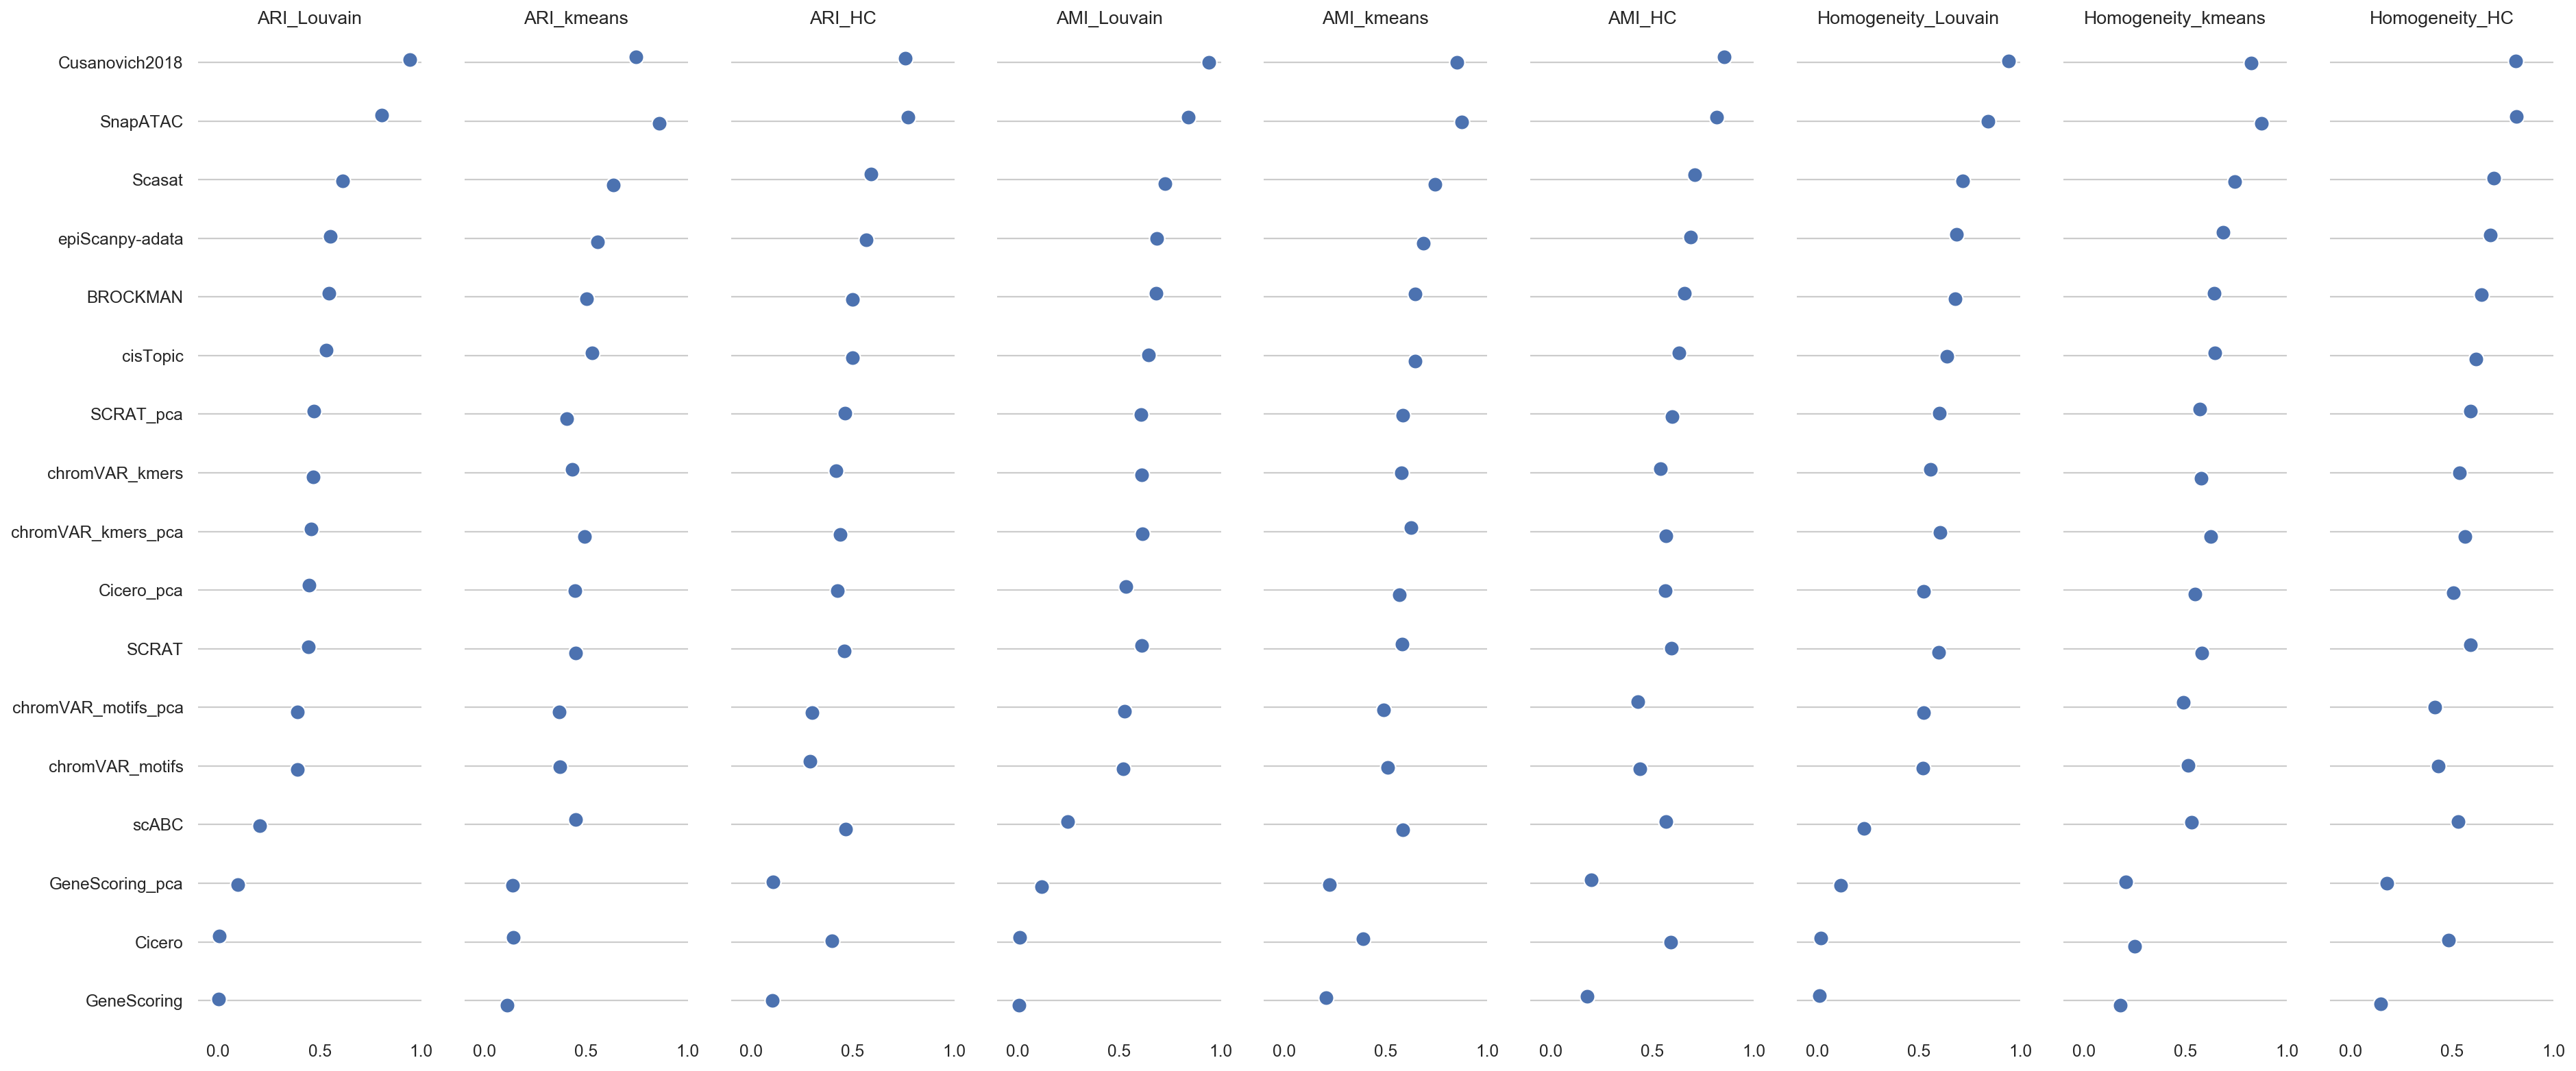

In [80]:
adata = adatareduced.copy()

from sklearn.metrics import adjusted_rand_score

labels_true = adata.obs['cell_type']
labels_pred = adata.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

############ Benchmarking
all_metrics = """Control	0.5928	0.569088	0.588754	0.714715	0.718895	0.723575	0.695935	0.701095	0.699836
BROCKMAN	0.54574	0.500141	0.499691	0.682654	0.642841	0.65918	0.67829	0.641288	0.645486
Cusanovich2018	0.943846	0.745106	0.758834	0.941653	0.851342	0.854749	0.941908	0.825158	0.813651
cisTopic	0.530953	0.529333	0.49712	0.645415	0.643513	0.629724	0.639389	0.644356	0.619491
chromVAR_kmers	0.467463	0.430748	0.417099	0.610438	0.577779	0.540338	0.555603	0.577083	0.537387
chromVAR_motifs	0.3906	0.369871	0.290375	0.520555	0.510661	0.43916	0.519439	0.512255	0.432029
chromVAR_kmers_pca	0.458582	0.492114	0.436538	0.612727	0.622779	0.568588	0.602843	0.624776	0.563519
chromVAR_motifs_pca	0.390955	0.367727	0.298085	0.524297	0.48803	0.427891	0.522027	0.489588	0.417594
GeneScoring	0.00267149	0.111998	0.103837	0.00570611	0.20693	0.179649	0.011055	0.1803	0.149194
GeneScoring_pca	0.09707	0.135782	0.106418	0.117303	0.222123	0.200712	0.113637	0.205834	0.179901
Cicero	0.00687868	0.142307	0.397534	0.0111747	0.389042	0.589552	0.0168549	0.249484	0.48291
Cicero_pca	0.448862	0.443354	0.423914	0.534053	0.566373	0.562634	0.522034	0.547409	0.50774
SnapATAC	0.804994	0.860076	0.770361	0.84069	0.874407	0.816767	0.841453	0.875022	0.816121
Scasat	0.613989	0.634201	0.590497	0.724743	0.74057	0.708525	0.715335	0.741861	0.705696
scABC	0.20426	0.448982	0.465818	0.247493	0.583171	0.568088	0.229539	0.529003	0.531906
SCRAT	0.444511	0.448028	0.457745	0.610931	0.581328	0.59356	0.596725	0.582187	0.592494
SCRAT_pca	0.469748	0.405095	0.461812	0.606473	0.585137	0.597519	0.601129	0.571914	0.591323
"""

    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy-adata'

# convert the cell label to standard label
adata.obs['label'] = adata.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adata.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adata,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.obsm['X_pca'])
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adata.obs['label'], adata.obs['louvain'])
ari_kmeans = adjusted_rand_score(adata.obs['label'], adata.obs['kmeans'])
ari_hc = adjusted_rand_score(adata.obs['label'], adata.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adata.obs['label'], adata.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adata.obs['label'], adata.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adata.obs['label'], adata.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adata.obs['label'], adata.obs['louvain'])
homo_kmeans = homogeneity_score(adata.obs['label'], adata.obs['kmeans'])
homo_hc = homogeneity_score(adata.obs['label'], adata.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    print(line)
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adata, color=['cell_type', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_Louvain",
                                        ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

df_metrics